In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
# Load Dataset
gpt_evaluations = pd.read_csv('./dataset_final.csv')
gpt_evaluations_sampled = (
    gpt_evaluations.groupby('model_name', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), 1200), random_state=43))
    .reset_index(drop=True)
)

/tmp/ipykernel_797373/1675409099.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 1200), random_state=43))


In [144]:
# Print the number of samples for each model_name
print(gpt_evaluations_sampled['model_name'].value_counts())

model_name
out-full-wfull-54M-r5    1200
out-local-w128-54M-r8    1200
out-local-w16-54M-r11    1200
out-local-w2-54M-r15     1200
out-local-w32-54M-r10    1200
out-local-w64-54M-r9     1200
out-slide-w128-54M-r9    1200
out-slide-w16-54M-r5     1200
out-slide-w2-54M-r10     1200
out-slide-w32-54M-r6     1200
out-slide-w64-54M-r7     1200
Name: count, dtype: int64


In [145]:
# Show sample dataset
gpt_evaluations_sampled.head()

,id,model_name,sentence,grammatical_correctness,readability,descriptiveness,coherence,conciseness,explanation,seed
0,9898,out-full-wfull-54M-r5,Implementing robust ethical guidelines and res...,9,9,9,9,8,Strong paragraph emphasizing key principles. U...,160086
1,11687,out-full-wfull-54M-r5,I’m quite fond of classic marinara sauce for p...,8,8,7,7,7,"Grammatically incorrect : ""marinara sauce for ...",478708
2,4506,out-full-wfull-54M-r5,I totally get that! Sun lifting and energizing...,10,10,10,10,10,"The sentence is grammatically correct, readabl...",111620
3,8654,out-full-wfull-54M-r5,"Additionally, I intend to continue investing i...",9,8,8,9,8,The sentences are grammatically accurate and c...,477515
4,4648,out-full-wfull-54M-r5,That’s a great way to put it—AI as an extensio...,10,9,8,9,8,Great sentence. Could be more concise by break...,518402


In [146]:
# Store result gruoped in a dictionary
models_dict = {name: group for name, group in gpt_evaluations_sampled.groupby('model_name')}
full_attention_model = models_dict['out-full-wfull-54M-r5']

fixed_attention_models = {k: v for k, v in models_dict.items() if 'local' in k}
sliding_attention_models = {k: v for k, v in models_dict.items() if 'slide' in k}
model_names = models_dict.keys()
# model_names



In [147]:
fixed_attention_models.keys()
len(fixed_attention_models.keys())

5

In [148]:
sliding_attention_models.keys()
len(fixed_attention_models.keys())

5

In [149]:
num_models = len(model_names) # There are 11 Models
num_models

11

In [150]:
metrics = ['grammatical_correctness', 'readability', 'descriptiveness', 'coherence', 'conciseness']
summary_table = gpt_evaluations_sampled.groupby('model_name')[metrics].mean().reset_index()
display(summary_table.style.hide(axis="index"))

model_name,grammatical_correctness,readability,descriptiveness,coherence,conciseness
out-full-wfull-54M-r5,8.793333,8.640000,8.475833,8.675000,8.145000
out-local-w128-54M-r8,8.772500,8.506667,8.473333,8.585833,8.076667
out-local-w16-54M-r11,7.525833,7.439167,7.534167,7.231667,6.941667
out-local-w2-54M-r15,5.907500,5.795833,6.260000,5.283333,5.445000
out-local-w32-54M-r10,8.320000,8.113333,8.127500,7.926667,7.676667
out-local-w64-54M-r9,8.564167,8.372500,8.351667,8.347500,7.890000
out-slide-w128-54M-r9,5.868333,5.759167,6.300833,5.400000,5.445833
out-slide-w16-54M-r5,5.617500,5.555833,6.092500,5.090000,5.151667
out-slide-w2-54M-r10,5.551667,5.480833,5.983333,5.092500,5.116667
out-slide-w32-54M-r6,5.824167,5.674167,6.244167,5.239167,5.261667


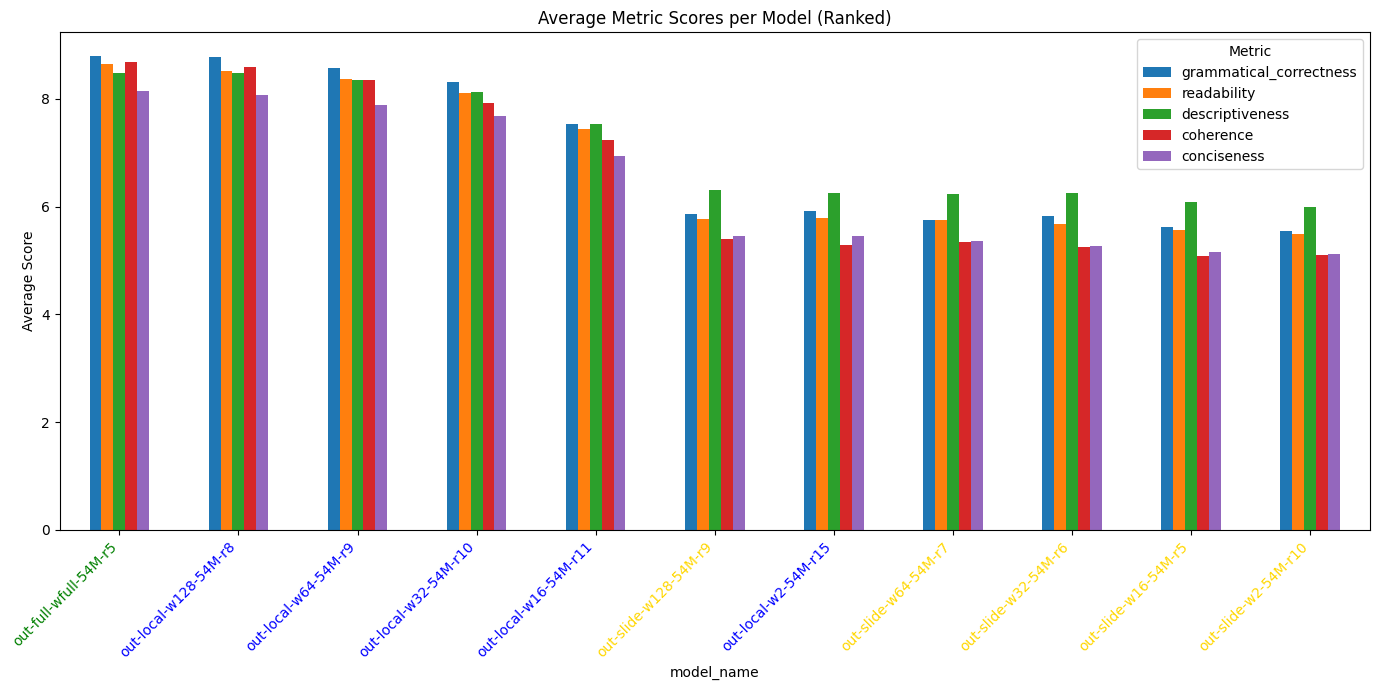

In [151]:
# Add average score column
summary_table['average_score'] = summary_table[metrics].mean(axis=1)

# Sort by average score (descending)
summary_table_ranked = summary_table.sort_values(by='average_score', ascending=False).reset_index(drop=True)

# Plot using the ranked table
ax = summary_table_ranked.set_index('model_name')[metrics].plot(kind='bar', figsize=(14, 7))
plt.ylabel('Average Score')
plt.title('Average Metric Scores per Model (Ranked)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()

# Color x-axis tick labels by model type
for label in ax.get_xticklabels():
    name = label.get_text()
    if 'full' in name:
        label.set_color('green')
    elif 'local' in name:
        label.set_color('blue')
    elif 'slide' in name:
        label.set_color('gold')  # 'yellow' is hard to read, 'gold' is better

plt.show()

In [152]:
def plot_radar(model_row, metrics):
    values = model_row[metrics].values.flatten().tolist()
    values += values[:1]  # repeat first value to close the circle
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title(f"Radar Plot for {model_row['model_name']}")
    plt.show()

# for idx, row in summary_table.iterrows():
#     plot_radar(row, metrics)

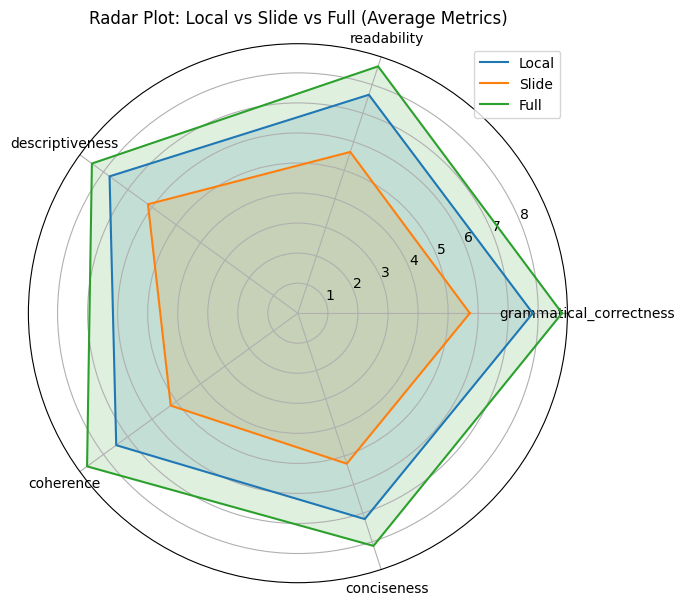

In [153]:
# Group model types
groups = {
    'local': summary_table[summary_table['model_name'].str.contains('local')],
    'slide': summary_table[summary_table['model_name'].str.contains('slide')],
    'full': summary_table[summary_table['model_name'].str.contains('full')],
}

# Calculate average metrics for each group
group_averages = {k: v[metrics].mean().tolist() for k, v in groups.items()}

# Radar plot setup
labels = metrics
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the circle

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for group, values in group_averages.items():
    stats = values + values[:1]  # close the circle
    ax.plot(angles, stats, label=group.capitalize())
    ax.fill(angles, stats, alpha=0.15)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar Plot: Local vs Slide vs Full (Average Metrics)")
plt.legend(loc='upper right')
plt.show()

In [154]:
# Calculate the average score across all metrics for each model
summary_table['average_score'] = summary_table[metrics].mean(axis=1)

# Sort models by average_score in descending order (best model first)
ranked_table = summary_table.sort_values(by='average_score', ascending=False).reset_index(drop=True)

# Add a rank column
ranked_table['rank'] = ranked_table.index + 1

# Display the ranked table
ranked_table[['rank', 'model_name', 'average_score']]
display(ranked_table[['rank', 'model_name', 'average_score']].style.hide(axis="index"))

rank,model_name,average_score
1,out-full-wfull-54M-r5,8.545833
2,out-local-w128-54M-r8,8.483000
3,out-local-w64-54M-r9,8.305167
4,out-local-w32-54M-r10,8.032833
5,out-local-w16-54M-r11,7.334500
6,out-slide-w128-54M-r9,5.754833
7,out-local-w2-54M-r15,5.738333
8,out-slide-w64-54M-r7,5.687500
9,out-slide-w32-54M-r6,5.648667
10,out-slide-w16-54M-r5,5.501500


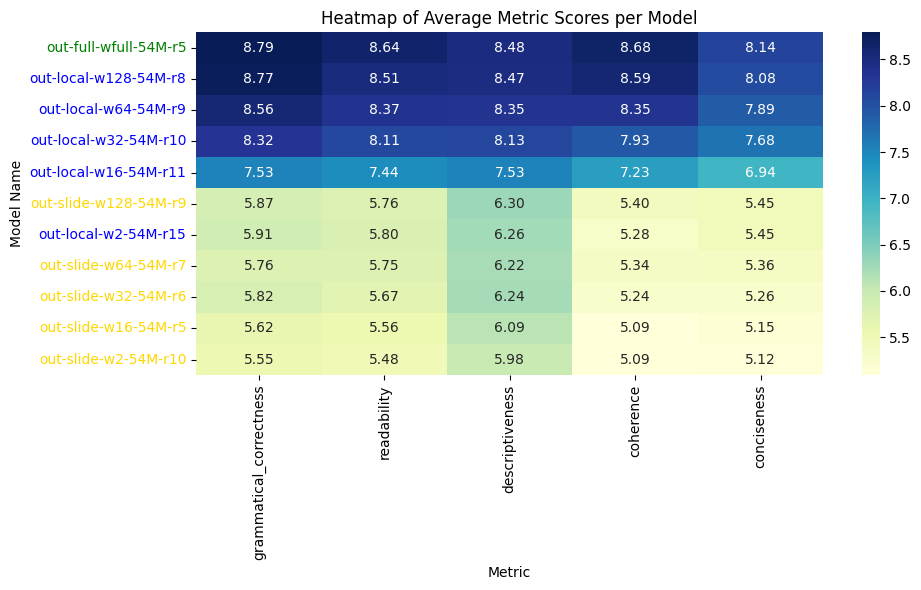

In [158]:
# Sort summary_table by average_score (descending) before plotting
summary_table['average_score'] = summary_table[metrics].mean(axis=1)
summary_table_sorted = summary_table.sort_values(by='average_score', ascending=False)

# Set model_name as index for the heatmap
heatmap_data = summary_table_sorted.set_index('model_name')[metrics]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Heatmap of Average Metric Scores per Model')
plt.ylabel('Model Name')
plt.xlabel('Metric')
plt.tight_layout()

# Set color for each model_name label
for label in ax.get_yticklabels():
    name = label.get_text()
    if 'full' in name:
        label.set_color('green')
    elif 'local' in name:
        label.set_color('blue')
    elif 'slide' in name:
        label.set_color('gold')  # 'yellow' is hard to read, 'gold' is better

plt.show()

In [156]:
# Get the benchmark score
benchmark_score = ranked_table.loc[ranked_table['model_name'] == 'out-full-wfull-54M-r5', 'average_score'].values[0]

# Calculate percentage of benchmark for each model
ranked_table['percent_of_benchmark'] = (ranked_table['average_score'] / benchmark_score) * 100

# Display the updated table
ranked_table[['rank', 'model_name', 'average_score', 'percent_of_benchmark']]# Display the updated table without the index
display(ranked_table[['rank', 'model_name', 'average_score', 'percent_of_benchmark']].style.hide(axis="index"))

rank,model_name,average_score,percent_of_benchmark
1,out-full-wfull-54M-r5,8.545833,100.000000
2,out-local-w128-54M-r8,8.483000,99.264749
3,out-local-w64-54M-r9,8.305167,97.183813
4,out-local-w32-54M-r10,8.032833,93.997075
5,out-local-w16-54M-r11,7.334500,85.825451
6,out-slide-w128-54M-r9,5.754833,67.340809
7,out-local-w2-54M-r15,5.738333,67.147733
8,out-slide-w64-54M-r7,5.687500,66.552901
9,out-slide-w32-54M-r6,5.648667,66.098489
10,out-slide-w16-54M-r5,5.501500,64.376402


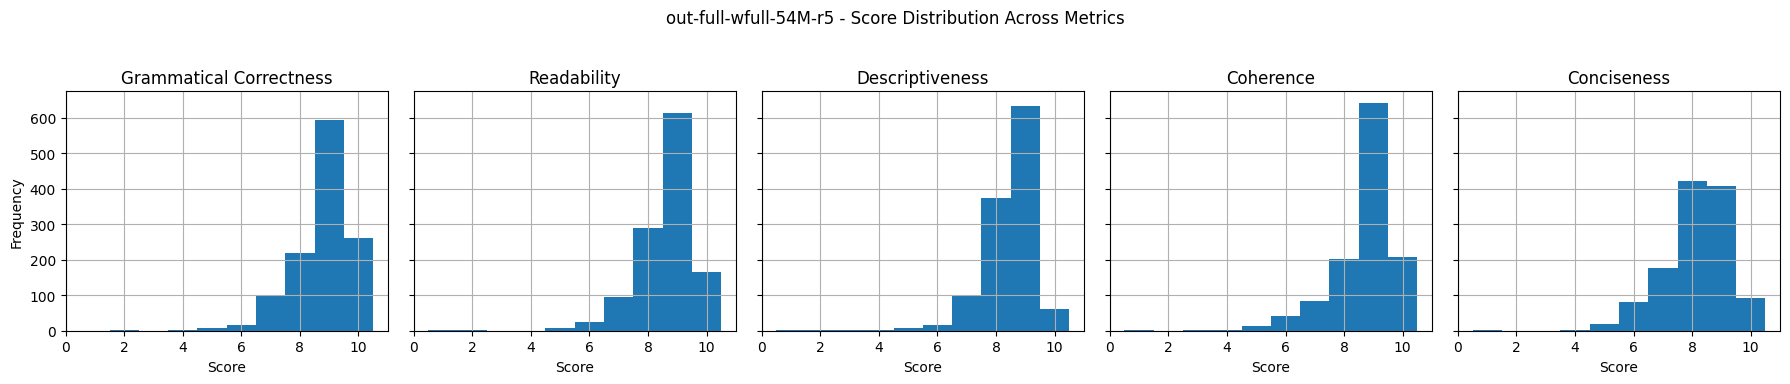

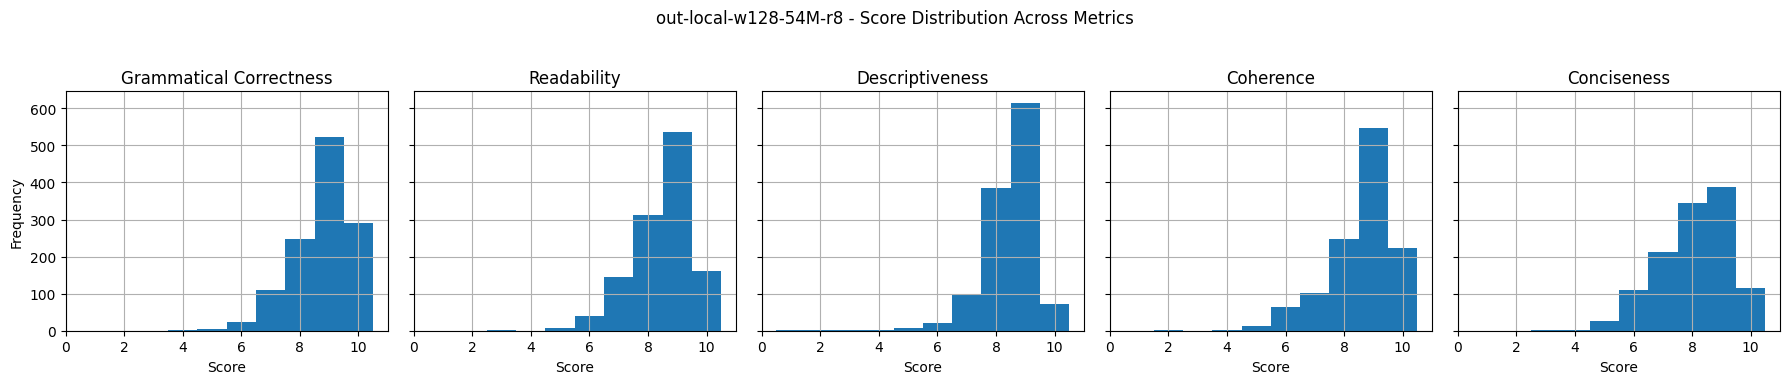

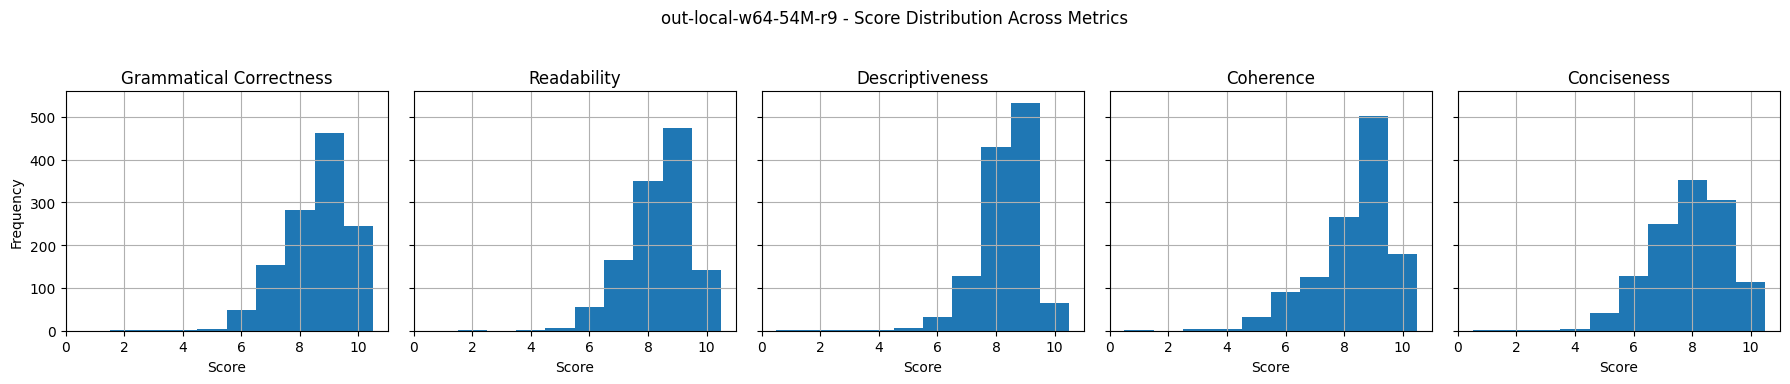

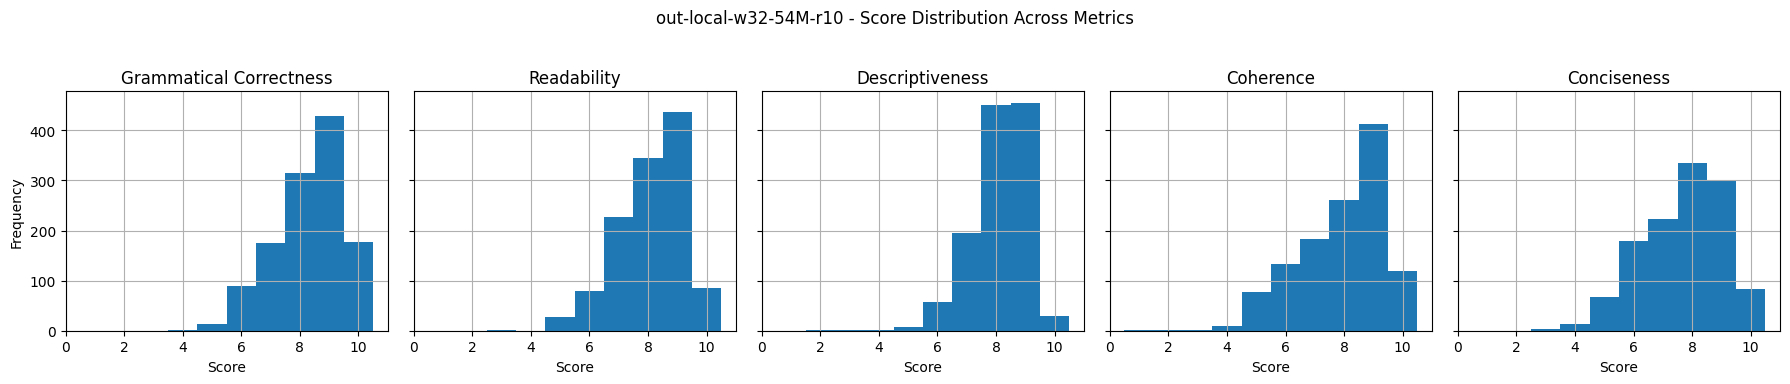

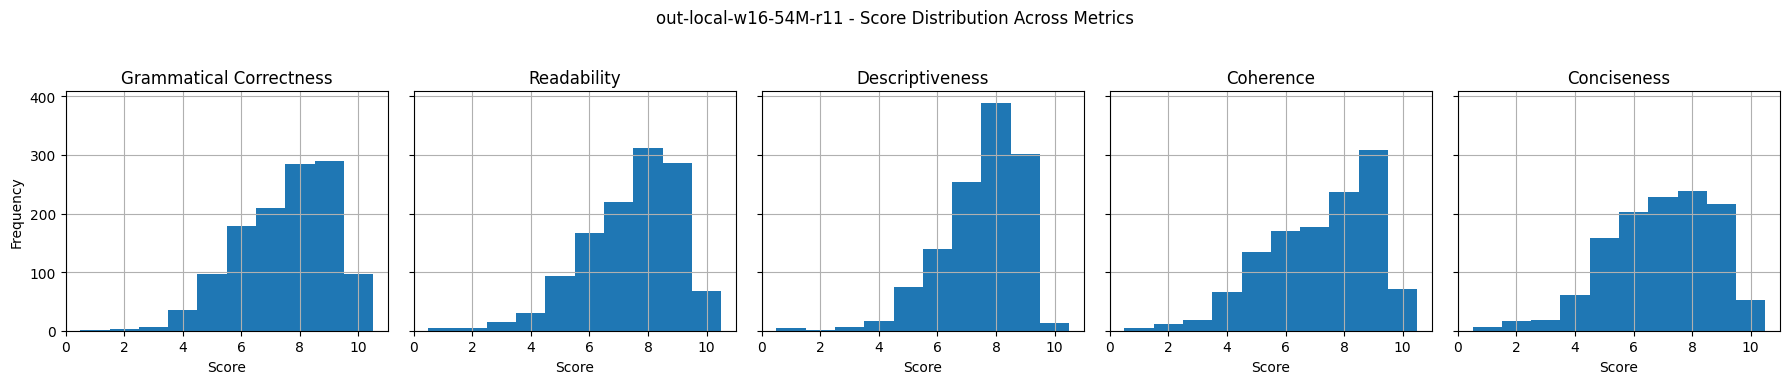

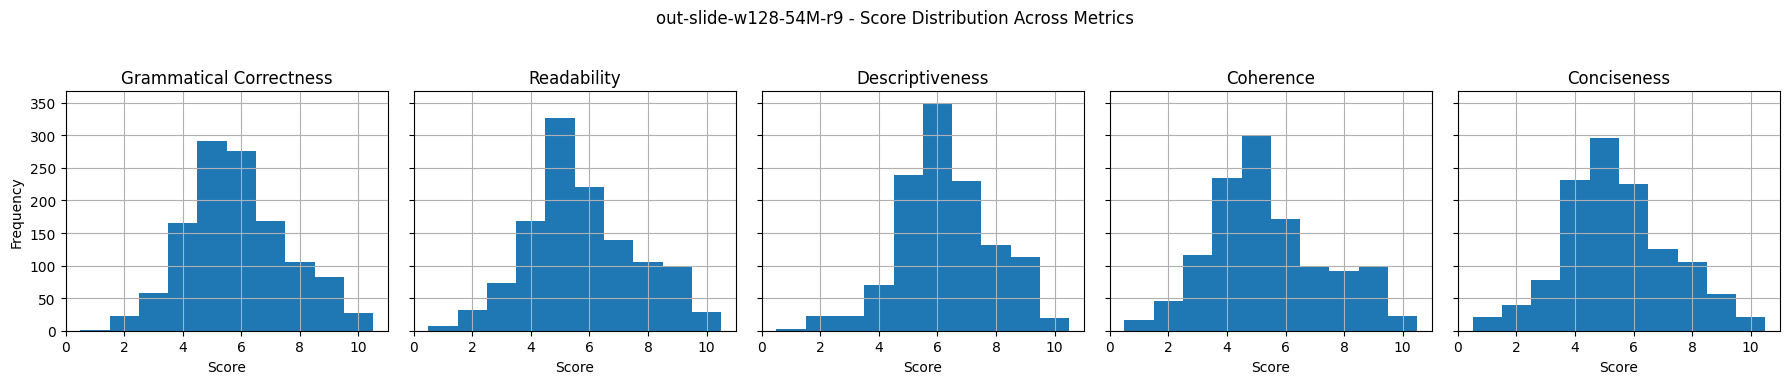

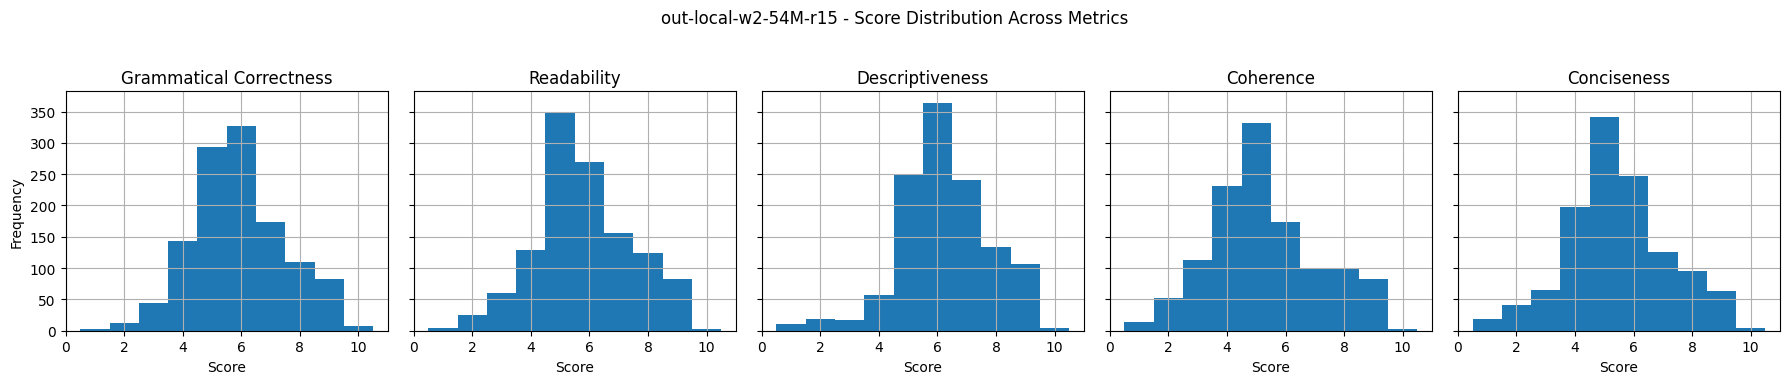

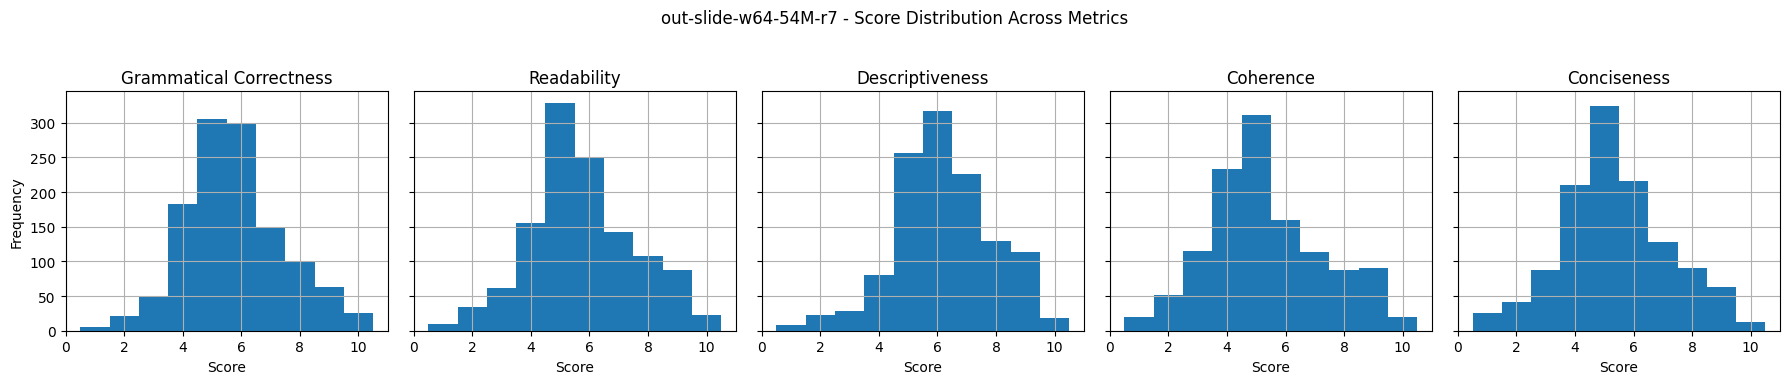

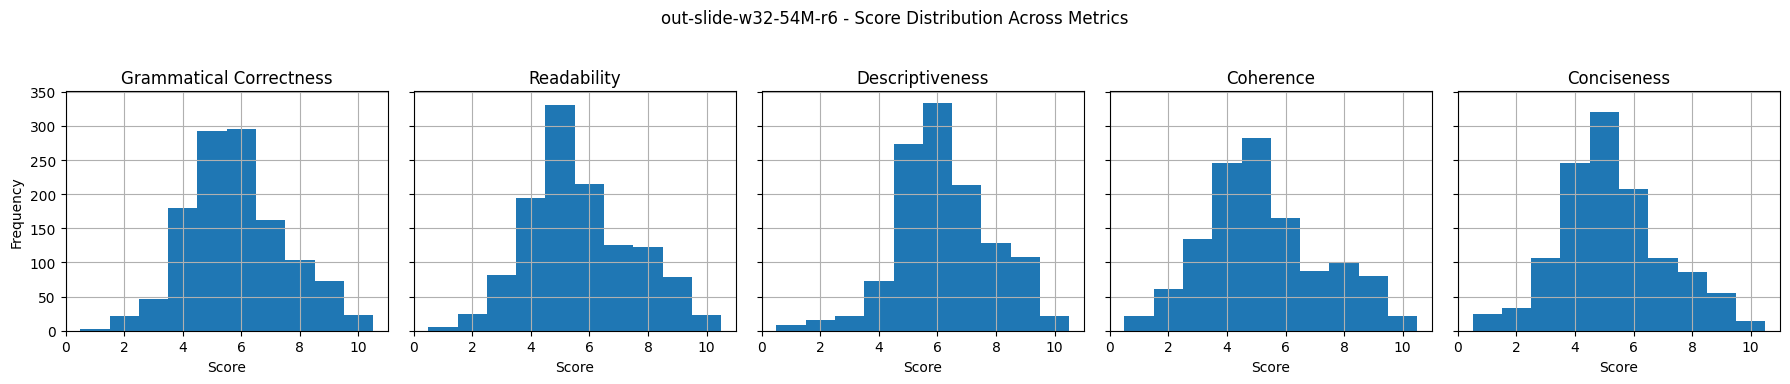

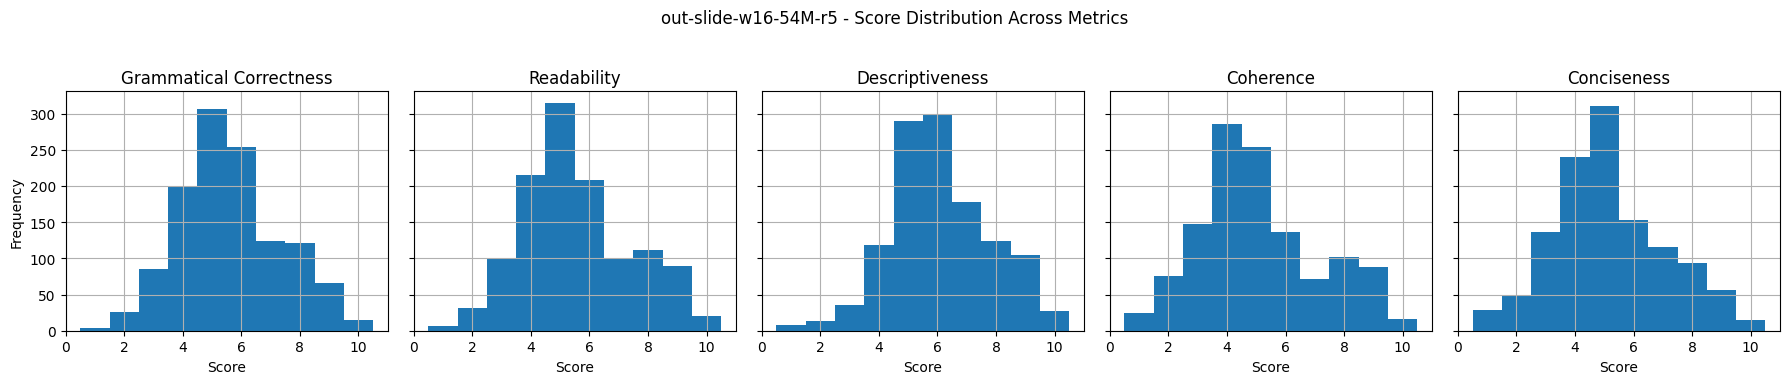

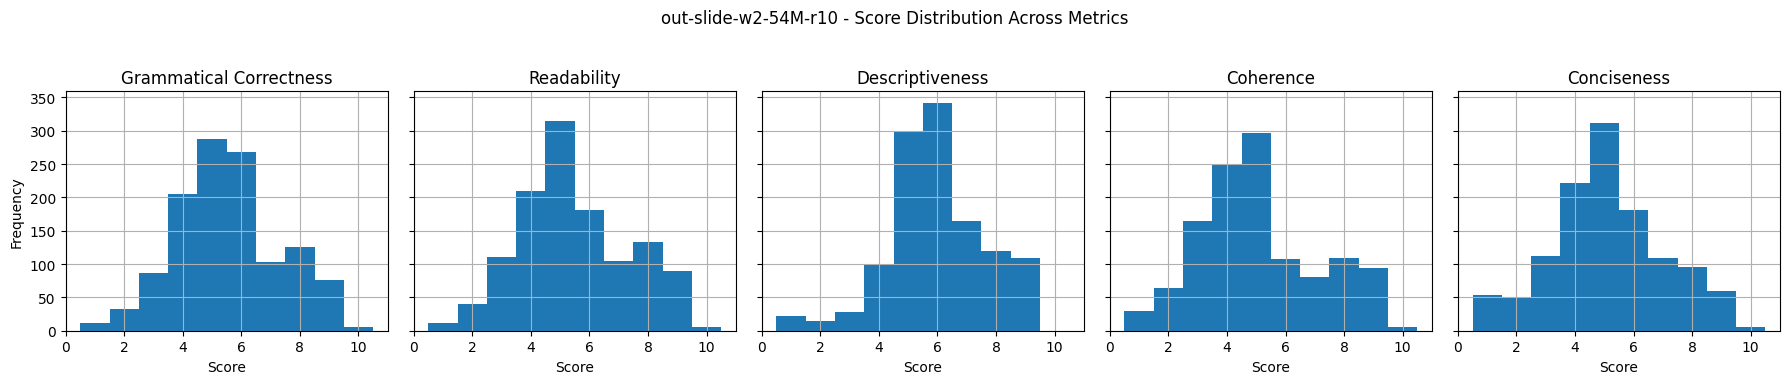

In [157]:
# Get sorted model names by average_score (descending)
sorted_models = ranked_table.sort_values(by='average_score', ascending=False)['model_name']

for model in sorted_models:
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 4), sharey=True)
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        gpt_evaluations_sampled[gpt_evaluations_sampled['model_name'] == model][metric].hist(
            bins=range(1, 12), align='left', ax=ax
        )
        ax.set_title(metric.replace('_', ' ').title())
        ax.set_xlabel('Score')
        if idx == 0:
            ax.set_ylabel('Frequency')
    plt.suptitle(f'{model} - Score Distribution Across Metrics')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()